# EDA Tiktok ads
**Goal**: Perform Exploratory Data Analysis (EDA) on scraped TikTok ads JSON data

**Context**: This feeds into a "Trend Insights" system for brand + persona development

Potential targeting strategies (by location, age and / or gender)

Temporal insights (ad start to end periods)

# Setup

In [74]:
from google.colab import drive
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pathlib
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, mannwhitneyu
from scipy import stats
from IPython.display import display
import ast

In [75]:
# Uncomment to mount Google Drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/FYP/tiktok_ads/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/FYP/tiktok_ads


In [76]:
df = pd.read_csv("tiktok_ads.csv")

# Load JSON
with open("tiktok_ads_catmum.json", "r") as f:
    data = json.load(f)
# Convert to DataFrame
df_catmum = pd.DataFrame(data)

# Display basic information about the dataset

<u>Summary of Findings (TikTok Ads Sample Data)</u>

**Shape**: (902, 18) – each row represents a TikTok ad entry.

**Data Types**:
* Categorical: adId, adTitle, adType, adVideoUrl, adVideoCover, advertiserId, advertiserName, advertiserPaidForBy, sourceQuery
* Numerical (float / int): adSpent, adTotalRegions, adEstimatedAudience, adImpressions (stored as ranges, e.g. 900K – 1M)
* Datetime (int64 epoch / datetime64 convertible): adStartDate, adEndDate
* Structured fields (JSON-like objects): targetingByLocation, targetingByAge, targetingByGender

In [77]:
print("Shape:", df.shape)
display(df.head())

Shape: (902, 18)


,adId,adTitle,adType,adSpent,adVideoUrl,adVideoCover,adStartDate,adEndDate,advertiserId,advertiserName,adImpressions,advertiserPaidForBy,adTotalRegions,adEstimatedAudience,targetingByLocation,targetingByAge,targetingByGender,sourceQuery
0,1799033420023841,Sports Supplements Ltd,2,NaN,https://library.tiktok.com/api/v1/cdn/17567945...,https://p16-csp-adlib-site-sign-sg.ibyteimg.co...,1715904000000,1756684800000,7111727353117803266,Sports Supplements Ltd,900K-1M,SPORTS SUPPLEMENTS LTD,1.0,900K-1M,"[{'region': 'IE', 'impressions': '938K'}]","[{'region': 'IE', '13-17': False, '18-24': Tru...","[{'region': 'IE', 'female': True, 'male': True...",sale
1,1792809468542002,Poproducts,2,NaN,https://library.tiktok.com/api/v1/cdn/17567945...,https://p19-csp-adlib-site-sign-sg.ibyteimg.co...,1709683200000,1756684800000,7343286979704143873,Poproducts,1K-10K,Poproducts,1.0,1K-10K,"[{'region': 'GB', 'impressions': '2K'}]","[{'region': 'GB', '13-17': False, '18-24': Tru...","[{'region': 'GB', 'female': True, 'male': True...",sale
2,1803948579717122,WSNL B.V.,2,NaN,NaN,NaN,1720310400000,1756684800000,7106468582065718018,WSNL B.V.,300K-400K,WSNL B.V.,1.0,300K-400K,"[{'region': 'NL', 'impressions': '315K'}]","[{'region': 'NL', '13-17': False, '18-24': Tru...","[{'region': 'NL', 'female': True, 'male': True...",sale
3,1803683972475922,WSNL B.V.,2,NaN,NaN,NaN,1720051200000,1756684800000,7106468582065718018,WSNL B.V.,200K-300K,WSNL B.V.,1.0,200K-300K,"[{'region': 'NL', 'impressions': '229K'}]","[{'region': 'NL', '13-17': False, '18-24': Tru...","[{'region': 'NL', 'female': True, 'male': True...",sale
4,1792809468803073,Poproducts,2,NaN,https://library.tiktok.com/api/v1/cdn/17567945...,https://p16-csp-adlib-site-sign-sg.ibyteimg.co...,1709683200000,1756684800000,7343286979704143873,Poproducts,1K-10K,Poproducts,1.0,1K-10K,"[{'region': 'GB', 'impressions': '5K'}]","[{'region': 'GB', '13-17': False, '18-24': Tru...","[{'region': 'GB', 'female': True, 'male': True...",sale


## Column Description

* adId: Unique identifier for the TikTok ad

* adTitle: Title of the ad (e.g. Sports Supplements Ltd)

* adType: Numeric code denoting the ad type / format

* adSpent: Total spent on the ad campaign

* adVideoUrl: Direct URL

* adVideoCover: URL to the cover image

* adStartDate: Ad start date (stored as epoch timestamp)

* adEndDate: Ad end date

* advertiserId: Unique identifier for the advertiser account

* advertiserName: Name of the advertiser

* adImpressions: Reported range of ad impressions

* advertiserPaidForBy: Entity that funded the advertisement (may be different from advertiserName)

* adTotalRegions: Number of regions / countries where the ad ran

* adEstimatedAudience: Estimated audience size reached

* targetingByLocation: JSON object listing regions targeted and impressions per region

* targetingByAge: JSON object describing targeted age groups (e.g. 18–24: True)

* targetingByGender: JSON object describing gender targeting (e.g. male: True, female: True)

* sourceQuery: Keyword(s) or category under which the ad was queried (e.g. sale)

## Inspect Data Structure

In [78]:
# Info
print(df.info())
print("\nNumber of Features:", df.shape[1])
print("Number of Data Points:", df.shape[0])

zero_nonnull_cols = df.columns[df.isna().all()].tolist()

# Drop them
df.drop(columns=zero_nonnull_cols, inplace=True)

# After cleanup
print("\nAfter dropping empty columns:")
print(df.info())
print("\nNumber of Features:", df.shape[1])
print("Number of Data Points:", df.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   adId                 902 non-null    int64  
 1   adTitle              902 non-null    object 
 2   adType               902 non-null    int64  
 3   adSpent              0 non-null      float64
 4   adVideoUrl           844 non-null    object 
 5   adVideoCover         844 non-null    object 
 6   adStartDate          902 non-null    int64  
 7   adEndDate            902 non-null    int64  
 8   advertiserId         902 non-null    int64  
 9   advertiserName       902 non-null    object 
 10  adImpressions        845 non-null    object 
 11  advertiserPaidForBy  902 non-null    object 
 12  adTotalRegions       845 non-null    float64
 13  adEstimatedAudience  902 non-null    object 
 14  targetingByLocation  845 non-null    object 
 15  targetingByAge       902 non-null    obj

In [79]:
# Check missing values
df.isnull().sum()

,0
adId,0
adTitle,0
adType,0
adVideoUrl,58
adVideoCover,58
adStartDate,0
adEndDate,0
advertiserId,0
advertiserName,0
adImpressions,57


In [80]:
#summary
display(df.describe(include="all").transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
adId,902.0,NaN,NaN,NaN,1825867093341055.75,15464101802857.919922,1777660420521010.0,1816235047047265.25,1830244399225393.0,1838609904956269.75,1842013463741489.0
adTitle,902,376,BENDING SPOONS OPERATIONS SPA,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adType,902.0,NaN,NaN,NaN,2.0,0.0,2.0,2.0,2.0,2.0,2.0
adVideoUrl,844,844,https://library.tiktok.com/api/v1/cdn/17567962...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adVideoCover,844,737,https://p21-ad-sg.ibyteimg.com/origin/tos-alis...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adStartDate,902.0,NaN,NaN,NaN,1741497557427.937988,14712941483.77392,1695254400000.0,1732298400000.0,1745928000000.0,1753898400000.0,1756598400000.0
adEndDate,902.0,NaN,NaN,NaN,1756485083813.747314,1093199470.840137,1747699200000.0,1756684800000.0,1756684800000.0,1756684800000.0,1756684800000.0
advertiserId,902.0,NaN,NaN,NaN,7214470913411980288.0,315069846298103936.0,0.0,7059423887234171904.0,7254516713304268800.0,7381852695629545472.0,7544817104525246464.0
advertiserName,902,376,BENDING SPOONS OPERATIONS SPA,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adImpressions,845,14,10K-100K,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Engineering

**Purpose**: Data cleaning and add useful fields for trend analysis & dashboards

In [81]:
def parse_impressions(x):
    #Convert range e.g. 900K-1M to numeric midpoint
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace(",", "")
    def _expand(v):
        if v.endswith(("K","k")): return float(v[:-1]) * 1_000
        if v.endswith(("M","m")): return float(v[:-1]) * 1_000_000
        return float(v)
    if "-" in s:
        lo, hi = s.split("-", 1)
        return (_expand(lo) + _expand(hi)) / 2.0
    return _expand(s)

def safe_literal(obj):
    if pd.isna(obj): return np.nan
    if isinstance(obj, (list, dict)): return obj
    try:
        return ast.literal_eval(str(obj))
    except Exception:
        return np.nan

def count_regions(loc_obj):
    obj = safe_literal(loc_obj)
    return len(obj) if isinstance(obj, (list, tuple)) else 0

def both_genders(gender_obj):
    obj = safe_literal(gender_obj)
    if isinstance(obj, list) and obj and isinstance(obj[0], dict):
        male = bool(obj[0].get("male"))
        female = bool(obj[0].get("female"))
        return male and female
    return np.nan

def relation_stats(df, x, y, bins=None, dropna=True):
    sub = df[[x, y]].copy()
    if dropna:
        sub = sub.dropna()

    if sub.shape[0] < 2 or sub[x].nunique() <= 1 or sub[y].nunique() <= 1:
        base = pd.DataFrame([{
            "x": x, "y": y, "N": sub.shape[0],
            "x_mean": sub[x].mean(), "x_std": sub[x].std(),
            "y_mean": sub[y].mean(), "y_std": sub[y].std(),
            "pearson_r": np.nan, "pearson_p": np.nan,
            "spearman_rho": np.nan, "spearman_p": np.nan,
            "slope": np.nan, "intercept": np.nan,
            "slope_p": np.nan, "slope_stderr": np.nan
        }])
        return base, None

    # Correlations
    pearson_r, pearson_p = stats.pearsonr(sub[x], sub[y])
    spearman_rho, spearman_p = stats.spearmanr(sub[x], sub[y])

    # Simple regression
    lr = stats.linregress(sub[x], sub[y])

    base = pd.DataFrame([{
        "x": x, "y": y, "N": sub.shape[0],
        "x_mean": sub[x].mean(), "x_std": sub[x].std(),
        "y_mean": sub[y].mean(), "y_std": sub[y].std(),
        "pearson_r": pearson_r, "pearson_p": pearson_p,
        "spearman_rho": spearman_rho, "spearman_p": spearman_p,
        "slope": lr.slope, "intercept": lr.intercept,
        "slope_p": lr.pvalue, "slope_stderr": lr.stderr
    }])

    # Optional binned summary on x
    binned = None
    if bins:
        if isinstance(bins, int):
            sub["_bin"] = pd.qcut(sub[x], q=bins, duplicates="drop")
        else:
            sub["_bin"] = pd.cut(sub[x], bins=bins, include_lowest=True)
        binned = (sub
                  .groupby("_bin", observed=True)
                  .agg(
                      N=(y, "size"),
                      x_min=(x, "min"),
                      x_max=(x, "max"),
                      y_mean=(y, "mean"),
                      y_median=(y, "median"),
                      y_std=(y, "std")
                  )
                  .reset_index())

    return base, binned

def group_diff_table(df, group_col, y, dropna=True):
    sub = df[[group_col, y]].copy()
    if dropna:
        sub = sub.dropna()

    summary = (sub
               .groupby(group_col, dropna=False)
               .agg(N=(y, "size"),
                    y_mean=(y, "mean"),
                    y_median=(y, "median"),
                    y_std=(y, "std"))
               .reset_index())

    groups = [g[y].values for _, g in sub.groupby(group_col)]
    test_name, stat, pval = None, np.nan, np.nan
    if len(groups) == 2:
        test_name = "Mann–Whitney U"
        stat, pval = stats.mannwhitneyu(groups[0], groups[1], alternative="two-sided")
    elif len(groups) >= 3:
        test_name = "One-way ANOVA"
        stat, pval = stats.f_oneway(*groups)

    test_tbl = pd.DataFrame([{"test": test_name, "stat": stat, "p_value": pval}])
    return summary, test_tbl

In [82]:
df["adImpressions_num"] = df["adImpressions"].apply(parse_impressions)

# Drop rows where impressions are missing
df = df.dropna(subset=["adImpressions_num"])

In [83]:
#Campaign Duration (End - Start)

df["adStartDate"] = pd.to_datetime(df["adStartDate"], unit="ms")
df["adEndDate"] = pd.to_datetime(df["adEndDate"], unit="ms")
df["campaignDuration_days"] = (df["adEndDate"] - df["adStartDate"]).dt.days

# Analysis

Tests relationships with campaignDuration_days, geographic reach & gender inclusivity impact

Correlation heatmap for numerical variables

In [84]:
desc_tbl = df["adImpressions_num"].describe(percentiles=[.25,.5,.75]).to_frame(name="adImpressions_num")
display(desc_tbl)

,adImpressions_num
count,8.450000e+02
mean,4.755124e+05
std,1.398991e+06
min,5.000000e+02
25%,5.500000e+03
50%,5.500000e+04
75%,2.500000e+05
max,1.500000e+07


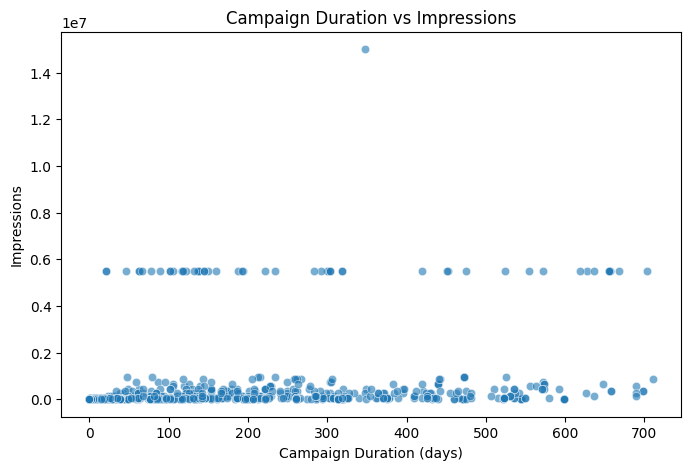

Relation Stats btwn campaignDuration_days & adImpressions_num


,x,y,N,x_mean,x_std,y_mean,y_std,pearson_r,pearson_p,spearman_rho,spearman_p,slope,intercept,slope_p,slope_stderr
0,campaignDuration_days,adImpressions_num,845,174.913609,173.141734,475512.426036,1.398991e+06,0.220858,8.531819e-11,0.549337,8.766402e-68,1784.540039,163372.086613,8.531819e-11,271.418919


Binned Summary (campaignDuration_days quantiles)


,_bin,N,x_min,x_max,y_mean,y_median,y_std
0,"(-0.001, 14.0]",170,0,14,10070.588235,500.0,1.926231e+04
1,"(14.0, 87.0]",169,15,87,309855.029586,55000.0,1.092733e+06
2,"(87.0, 172.0]",170,88,172,649191.176471,55000.0,1.578112e+06
3,"(172.0, 307.2]",167,173,307,540832.335329,55000.0,1.341965e+06
4,"(307.2, 711.0]",169,308,711,870112.426036,150000.0,1.978667e+06


In [85]:
# Campaign Duration
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="campaignDuration_days", y="adImpressions_num", alpha=0.6)
plt.title("Campaign Duration vs Impressions")
plt.xlabel("Campaign Duration (days)")
plt.ylabel("Impressions")
plt.show()

base_tbl, binned_tbl = relation_stats(df, x="campaignDuration_days", y="adImpressions_num", bins=5)
print("Relation Stats btwn campaignDuration_days & adImpressions_num")
display(base_tbl)
print("Binned Summary (campaignDuration_days quantiles)")
display(binned_tbl)

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22025 (\N{CJK UNIFIED IDEOGRAPH-5609}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20852 (\N{CJK UNIFIED IDEOGRAPH-5174}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36920 (\N{CJK UNIFIED IDEOGRAPH-9038}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from font(s) DejaVu Sans.
  fig.canvas

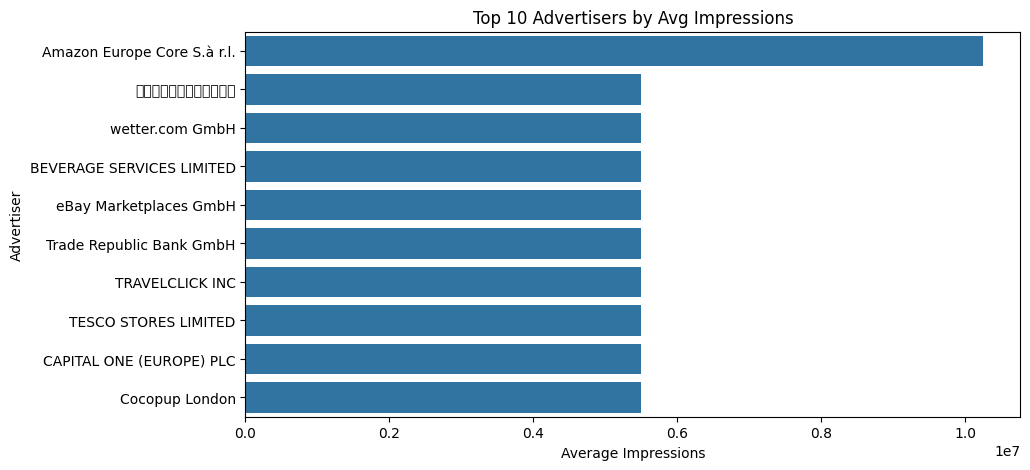

Top 10 Advertisers by Avg Impressions (table)


,avg_impressions
advertiserName,
Amazon Europe Core S.à r.l.,10250000.0
嘉兴逸新网络技术有限公司,5500000.0
wetter.com GmbH,5500000.0
BEVERAGE SERVICES LIMITED,5500000.0
eBay Marketplaces GmbH,5500000.0
Trade Republic Bank GmbH,5500000.0
TRAVELCLICK INC,5500000.0
TESCO STORES LIMITED,5500000.0
CAPITAL ONE (EUROPE) PLC,5500000.0


In [86]:
# Advertiser Analysis
top_adv = (df.groupby("advertiserName")["adImpressions_num"]
             .mean().sort_values(ascending=False).head(10))
plt.figure(figsize=(10,5))
sns.barplot(x=top_adv.values, y=top_adv.index)
plt.title("Top 10 Advertisers by Avg Impressions")
plt.xlabel("Average Impressions")
plt.ylabel("Advertiser")
plt.show()

print("Top 10 Advertisers by Avg Impressions (table)")
display(top_adv.to_frame(name="avg_impressions"))

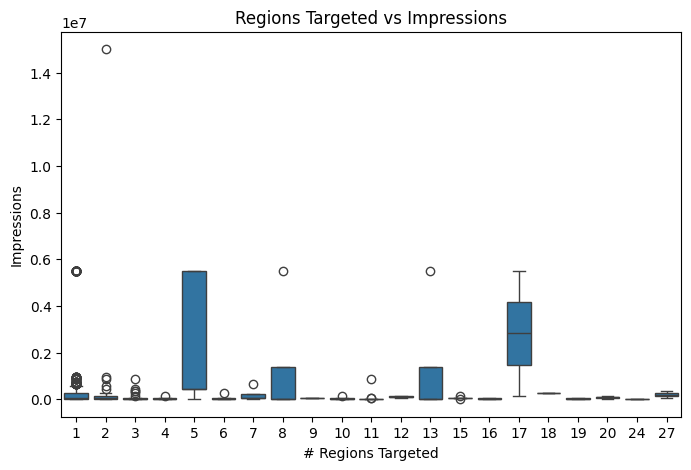

Relation Stats btwn numRegionsTargeted & adImpressions_num


,x,y,N,x_mean,x_std,y_mean,y_std,pearson_r,pearson_p,spearman_rho,spearman_p,slope,intercept,slope_p,slope_stderr
0,numRegionsTargeted,adImpressions_num,845,2.325444,3.905201,475512.426036,1.398991e+06,-0.046365,0.178137,-0.185712,5.393417e-08,-16609.747739,514137.460718,0.178137,12325.095257


Binned Summary


,_bin,N,x_min,x_max,y_mean,y_median,y_std
0,"(-0.001, 1.0]",682,1,1,5.077705e+05,55000.0,1.373727e+06
1,"(1.0, 2.0]",38,2,2,5.210921e+05,55000.0,2.422357e+06
2,"(2.0, 3.0]",26,3,3,9.994231e+04,5500.0,2.004524e+05
3,"(3.0, 4.0]",14,4,4,2.464286e+04,5500.0,4.226811e+04
4,"(4.0, 5.0]",5,5,5,2.380100e+06,450000.0,2.853972e+06
5,"(5.0, 6.0]",10,6,6,4.480000e+04,5500.0,7.578192e+04
6,"(6.0, 7.0]",4,7,7,1.913750e+05,55000.0,3.066391e+05
7,"(7.0, 8.0]",4,8,8,1.375375e+06,500.0,2.749750e+06
8,"(8.0, 9.0]",1,9,9,5.500000e+04,55000.0,NaN
9,"(9.0, 10.0]",4,10,10,4.037500e+04,5500.0,7.312133e+04


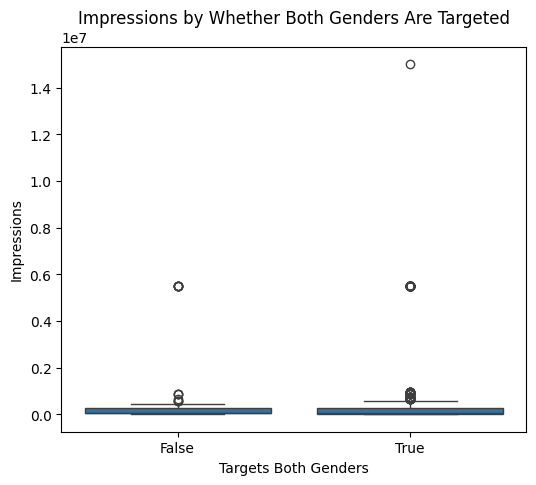

Summary: targetsBothGenders


,targetsBothGenders,N,y_mean,y_median,y_std
0,False,107,448705.607477,55000.0,1.251013e+06
1,True,738,479399.051491,55000.0,1.419898e+06


Group Difference Test


,test,stat,p_value
0,Mann–Whitney U,46963.5,0.001236


In [87]:
# Targeting Analysis (Regions, Gender)
df["numRegionsTargeted"] = df["targetingByLocation"].apply(count_regions)

plt.figure(figsize=(8,5))
sns.boxplot(x=df["numRegionsTargeted"], y=df["adImpressions_num"])
plt.title("Regions Targeted vs Impressions")
plt.xlabel("# Regions Targeted")
plt.ylabel("Impressions")
plt.show()

base_tbl, binned_tbl = relation_stats(
    df, x="numRegionsTargeted", y="adImpressions_num",
    bins=range(0, df["numRegionsTargeted"].max() + 1)
)
print("Relation Stats btwn numRegionsTargeted & adImpressions_num")
display(base_tbl)
print("Binned Summary")
display(binned_tbl)

# convert genders to boolean flag
df["targetsBothGenders"] = df["targetingByGender"].apply(both_genders)

plt.figure(figsize=(6,5))
sns.boxplot(x="targetsBothGenders", y="adImpressions_num", data=df)
plt.title("Impressions by Whether Both Genders Are Targeted")
plt.xlabel("Targets Both Genders")
plt.ylabel("Impressions")
plt.show()

grp_tbl, test_tbl = group_diff_table(df, group_col="targetsBothGenders", y="adImpressions_num")
print("Summary: targetsBothGenders")
display(grp_tbl)
print("Group Difference Test")
display(test_tbl)


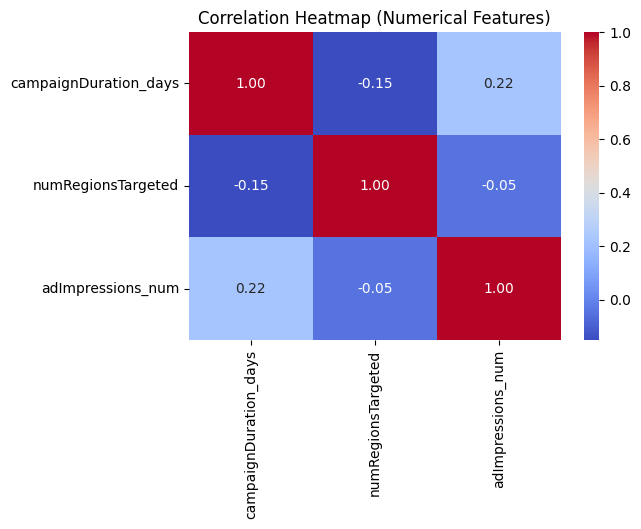

Correlation Heatmap


,feature_1,feature_2,corr
0,adImpressions_num,campaignDuration_days,0.220858
1,adImpressions_num,numRegionsTargeted,-0.046365
2,campaignDuration_days,numRegionsTargeted,-0.150792


In [88]:
# Correlation Heatmap
num_cols = ["campaignDuration_days", "numRegionsTargeted", "adImpressions_num"]
corr = df[num_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

print("Correlation Heatmap")
corr_tbl = corr.unstack().rename("corr").reset_index()
corr_tbl.columns = ["feature_1", "feature_2", "corr"]
mask = corr_tbl["feature_1"] < corr_tbl["feature_2"]
display(corr_tbl[mask].sort_values("corr", ascending=False).reset_index(drop=True))

## Univariate Analysis

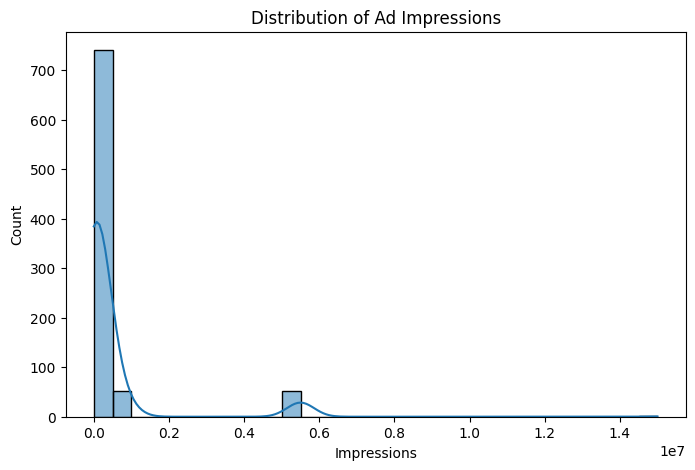

In [89]:
plt.figure(figsize=(8,5))
sns.histplot(df["adImpressions_num"], bins=30, kde=True)
plt.title("Distribution of Ad Impressions")
plt.xlabel("Impressions")
plt.show()

## Interpretation

Campaign duration is the strongest, clearest signal
* Pearson r = 0.221 (p ≈ 8.5e-11) => a small but highly significant linear association.

* Spearman ρ = 0.549 (p ≈ 8.8e-68) => a strong monotonic relationship i.e. longer campaigns generally rack up more impressions

* Slope ≈ 1,785 impressions/day (SE ≈ 271; p ≈ 8.5e-11).

* Bins tell the story: mean impressions rise from ~10k (<=14 days) to ~870k (>=308 days). Medians jump at the extremes (500 => 150k), consistent with time-on-air accumulation and a heavy-tailed distribution.

Number of regions targeted isn’t a reliable driver
* Pearson r = −0.046 (p = 0.178) => no meaningful linear relationship.

* Spearman ρ = −0.186 (p ≈ 5.4e-08) => statistically significant but small inverse rank association.

* Slope ≈ −16.6k per extra region (NS; p = 0.178).

* Bins are noisy / non-monotonic: most campaigns are single-region (N=682) with high variance; a few multi-region bins show spikes (e.g., 5, 7, 12, 17 regions) driven by rare, extreme outliers.

Gender targeting: statistically different, practically similar

Targeting both genders is associated with slightly higher impressions on average, but typical performance (median) is similar.

* Targets both genders (True): mean ≈ 479k; False: ≈ 449k.
Medians are identical (55k).

* Mann–Whitney U p ≈ 0.0012 => distributions differ, but the effect size is small and differences are in the upper tail, not the typical case (same medians).

Correlations overview (numerics)

* adImpressions_num vs campaignDuration_days: +0.221 (main signal)

* adImpressions_num vs numRegionsTargeted: −0.046 (weak)

* campaignDuration_days vs numRegionsTargeted: −0.151 (weak)